In [ ]:
from pathlib import Path
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "drive/MyDrive/Sampling images/coco_20_samples"

coco_sample_000.jpg  coco_sample_009.jpg  coco_sample_018.jpg
coco_sample_001.jpg  coco_sample_010.jpg  coco_sample_019.jpg
coco_sample_002.jpg  coco_sample_011.jpg  gt_512
coco_sample_003.jpg  coco_sample_012.jpg  outputs
coco_sample_004.jpg  coco_sample_013.jpg  stripe_control_512
coco_sample_005.jpg  coco_sample_014.jpg  striped_512
coco_sample_006.jpg  coco_sample_015.jpg  stripe_sampling_results
coco_sample_007.jpg  coco_sample_016.jpg
coco_sample_008.jpg  coco_sample_017.jpg


In [ ]:
import os
from pathlib import Path

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

from diffusers import StableDiffusionControlNetPipeline, UNet2DConditionModel, ControlNetModel, StableDiffusionControlNetInpaintPipeline
from safetensors.torch import load_file
from PIL import Image

import matplotlib.pyplot as plt

In [ ]:
!ls "drive/MyDrive/Experiments_Stripes/controlnet_stripes_v1/checkpoint-epoch-resumed-3"

config.json  diffusion_pytorch_model.safetensors


In [ ]:
BASE_MODEL = "runwayml/stable-diffusion-v1-5"

DATA_ROOT = Path("drive/MyDrive/Sampling images/coco_20_samples")

CONTROLNET_CKPT = "drive/MyDrive/Experiments_Stripes/controlnet_stripes_v1/checkpoint-epoch-resumed-3"

DEVICE = "cuda"
IMG_SIZE = 512

RESULTS_DIR = DATA_ROOT / "stripe_sampling_results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print("Results will be saved to:", RESULTS_DIR)

Results will be saved to: drive/MyDrive/Sampling images/coco_20_samples/stripe_sampling_results


In [ ]:
class StripeControlNetDataset(Dataset):
    def __init__(self, root: Path, image_size=512):
        self.root = root
        self.gt_dir = self.root / "gt_512"
        self.striped_dir = self.root / "striped_512"
        self.control_dir = self.root / "stripe_control_512"

        self.files = sorted(self.gt_dir.glob("*.jpg"))
        assert len(self.files) > 0, f"No images in {self.gt_dir}"

        self.image_size = image_size
        self.to_tensor = transforms.ToTensor()
        self.resize = transforms.Resize((image_size, image_size))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        gt_path = self.files[idx]
        stem = gt_path.stem

        striped_path = self.striped_dir / f"{stem}.jpg"
        control_path = self.control_dir / f"{stem}.png"

        gt = Image.open(gt_path).convert("RGB")
        striped = Image.open(striped_path).convert("RGB")
        control = Image.open(control_path).convert("L")

        gt = self.resize(gt)
        striped = self.resize(striped)
        control = self.resize(control)

        gt_t = self.to_tensor(gt)         # (3,H,W), [0,1]
        striped_t = self.to_tensor(striped)
        control_t = self.to_tensor(control)  # (1,H,W), [0,1]

        # ControlNet condition: 4 channels = striped RGB + stripe control
        control_cond = torch.cat([striped_t, control_t], dim=0)  # (4,H,W)

        return {"H": gt_t, "control": control_cond, "stem": stem}

dataset = StripeControlNetDataset(DATA_ROOT, image_size=IMG_SIZE)
print("Sampling dataset size:", len(dataset))

Sampling dataset size: 20


In [ ]:
dataset

In [ ]:
# 1) UNet just for architecture
unet_for_arch = UNet2DConditionModel.from_pretrained(BASE_MODEL, subfolder="unet")

# 2) Build ControlNet from that UNet
controlnet = ControlNetModel.from_unet(unet_for_arch)

# 3) Patch conv_in to 4 channels (3 striped RGB + 1 stripe_control)
orig_conv = controlnet.controlnet_cond_embedding.conv_in
new_conv = torch.nn.Conv2d(
    4,  # in_channels
    orig_conv.out_channels,
    kernel_size=3,
    stride=1,
    padding=1,
)
controlnet.controlnet_cond_embedding.conv_in = new_conv

# 4) Load trained weights
sft_path = os.path.join(CONTROLNET_CKPT, "diffusion_pytorch_model.safetensors")
bin_path = os.path.join(CONTROLNET_CKPT, "diffusion_pytorch_model.bin")

if os.path.exists(sft_path):
    print("Loading ControlNet weights from .safetensors")
    state_dict = load_file(sft_path, device="cpu")
elif os.path.exists(bin_path):
    print("Loading ControlNet weights from .bin")
    state_dict = torch.load(bin_path, map_location="cpu")
else:
    raise FileNotFoundError(f"No weights file found in {CONTROLNET_CKPT}")

missing, unexpected = controlnet.load_state_dict(state_dict, strict=False)
print("Loaded ControlNet. Missing keys:", missing)
print("Unexpected keys:", unexpected)



# Check for CUDA availability and set device accordingly
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
controlnet.to(DEVICE, dtype=torch.float16 if DEVICE == "cuda" else torch.float32)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading ControlNet weights from .safetensors
Loaded ControlNet. Missing keys: []
Unexpected keys: []


ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (conv_out): Conv2d(256, 320, ker

In [ ]:
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
)
pipe.to(DEVICE)
pipe.set_progress_bar_config(disable=False)

# If xformers is installed, you can enable this (optional)
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("Enabled xFormers attention.")
except Exception as e:
    print("xFormers not enabled:", e)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
def run_sampling_over_all(num_inference_steps=30, guidance_scale=7.5, cond_scale=1.0, seed=42):
    generator = torch.Generator(device=DEVICE).manual_seed(seed)

    for idx in range(len(dataset)):
        sample = dataset[idx]
        gt = sample["H"]               # (3,H,W), [0,1]
        control = sample["control"]    # (4,H,W), [0,1] - this is control_cond
        stem = sample["stem"]

        control_batch = control.unsqueeze(0).to(DEVICE, dtype=pipe.dtype)

        # Extract striped image and mask from control_batch
        striped_image_for_inpainting = to_pil_image(control_batch[0, :3])
        mask_image_for_inpainting = to_pil_image(control_batch[0, 3:])

        with torch.autocast("cuda" if DEVICE == "cuda" else "cpu"):
            out = pipe(
                prompt=["a sharp, high-quality photograph"],
                image=striped_image_for_inpainting, # The image to be inpainted
                mask_image=mask_image_for_inpainting, # The mask for inpainting
                control_image=control_batch, # The 4-channel control input for ControlNet
                num_inference_steps=num_inference_steps,
                guidance_scale=guidance_scale,
                controlnet_conditioning_scale=cond_scale,
                generator=generator,
            )

        gen_pil = out.images[0]

        striped_rgb = control[:3]  # (3,H,W)
        striped_pil = to_pil_image(striped_rgb)
        gt_pil = to_pil_image(gt)

        # [striped | generated | gt]
        w, h = IMG_SIZE, IMG_SIZE
        row = Image.new("RGB", (w * 3, h))
        row.paste(striped_pil, (0, 0))
        row.paste(gen_pil, (w, 0))
        row.paste(gt_pil, (2 * w, 0))

        save_path = RESULTS_DIR / f"{stem}_triplet.png"
        row.save(save_path)
        print(f"Saved {save_path}")

    print("Sampling complete.")

# Run sampling
run_sampling_over_all(num_inference_steps=30, guidance_scale=7.5, cond_scale=1.0, seed=42)

  0%|          | 0/30 [00:00<?, ?it/s]

Saved drive/MyDrive/Sampling images/coco_20_samples/stripe_sampling_results/coco_sample_000_triplet.png


  0%|          | 0/30 [00:00<?, ?it/s]

Saved drive/MyDrive/Sampling images/coco_20_samples/stripe_sampling_results/coco_sample_001_triplet.png


  0%|          | 0/30 [00:00<?, ?it/s]

Saved drive/MyDrive/Sampling images/coco_20_samples/stripe_sampling_results/coco_sample_002_triplet.png


  0%|          | 0/30 [00:00<?, ?it/s]

Saved drive/MyDrive/Sampling images/coco_20_samples/stripe_sampling_results/coco_sample_003_triplet.png


  0%|          | 0/30 [00:00<?, ?it/s]

Saved drive/MyDrive/Sampling images/coco_20_samples/stripe_sampling_results/coco_sample_004_triplet.png


  0%|          | 0/30 [00:00<?, ?it/s]

Saved drive/MyDrive/Sampling images/coco_20_samples/stripe_sampling_results/coco_sample_005_triplet.png


  0%|          | 0/30 [00:00<?, ?it/s]

Saved drive/MyDrive/Sampling images/coco_20_samples/stripe_sampling_results/coco_sample_006_triplet.png


  0%|          | 0/30 [00:00<?, ?it/s]

Saved drive/MyDrive/Sampling images/coco_20_samples/stripe_sampling_results/coco_sample_007_triplet.png


  0%|          | 0/30 [00:00<?, ?it/s]

Saved drive/MyDrive/Sampling images/coco_20_samples/stripe_sampling_results/coco_sample_008_triplet.png


  0%|          | 0/30 [00:00<?, ?it/s]

Saved drive/MyDrive/Sampling images/coco_20_samples/stripe_sampling_results/coco_sample_009_triplet.png


KeyboardInterrupt: 

In [ ]:
# Install necessary libraries
!pip install -q diffusers transformers accelerate bitsandbytes

# Core imports
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from diffusers import AutoencoderKL, UNet2DConditionModel, ControlNetModel, DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator
from tqdm.auto import tqdm
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 43.4 MB/s eta 0:00:00


In [ ]:
!ls "drive/MyDrive/Experiments_Stripes/controlnet_stripes_v1/checkpoint-epoch-resumed-3"

config.json  diffusion_pytorch_model.safetensors


In [ ]:
# =================================================================
# == Cell 2: Configuration
# =================================================================
!pip install --upgrade diffusers transformers accelerate -q
# --- 1. SET THE PATH TO YOUR CHECKPOINT ---
# Example for an end-of-epoch save:
CHECKPOINT_DIR = "/content/drive/MyDrive/Experiments_Stripes1/controlnet_stripes_v1/checkpoint-epoch-8"
# Example for the crash-recovery save:


# --- 2. SET THE PATH TO YOUR DATASET ---
# This is needed to load the validation image and its prior.
# You might need to re-download/unzip it if you're in a new session.
DATA_ROOT = "drive/MyDrive/Sampling images/coco_20_samples"

# --- 3. CHOOSE WHICH VALIDATION IMAGE TO TEST ---

# --- Other Settings ---
BASE_MODEL_ID = "runwayml/stable-diffusion-v1-5"

In [ ]:
# == Cell 3: Load the Trained Model (Robust Version with Safetensors)
# =================================================================
from diffusers import UNet2DConditionModel,StableDiffusionControlNetImg2ImgPipeline
from safetensors.torch import load_file
from transformers import CLIPTextModel, CLIPTokenizer # Import CLIPTextModel and CLIPTokenizer
from PIL import Image

print(f"📂 Preparing to load trained ControlNet from {CHECKPOINT_DIR}...")

# --- 1. Define the path to your trained ControlNet folder ---
controlnet_path = CHECKPOINT_DIR
# controlnet_path = os.path.join(CHECKPOINT_DIR, "controlnet")

# --- 2. Manually build the correct ControlNet architecture in memory ---
print("Building model architecture from U-Net template...")
unet_template = UNet2DConditionModel.from_pretrained(
    BASE_MODEL_ID, subfolder="unet", torch_dtype=torch.float32
)
controlnet = ControlNetModel.from_unet(unet_template)
controlnet.controlnet_cond_embedding.conv_in = torch.nn.Conv2d(
    4, controlnet.controlnet_cond_embedding.conv_in.out_channels, kernel_size=3, padding=1
)

# --- 3. **NEW: Intelligently find and load the weights file** ---
print(f"Loading saved weights from {controlnet_path}...")
weights_file_safetensors = os.path.join(controlnet_path, "diffusion_pytorch_model.safetensors")
weights_file_bin = os.path.join(controlnet_path, "diffusion_pytorch_model.bin")

if os.path.exists(weights_file_safetensors):
    print("Found .safetensors file. Loading...")
    saved_weights = load_file(weights_file_safetensors, device="cpu")
elif os.path.exists(weights_file_bin):
    print("Found .bin file. Loading...")
    saved_weights = torch.load(weights_file_bin, map_location="cpu")
else:
    raise FileNotFoundError(f"Could not find model weights file in {controlnet_path}")

# Load the weights into your correctly-shaped model
controlnet.load_state_dict(saved_weights)

# --- 4. Load the full pipeline, injecting our fully-built ControlNet ---
print("Building final inference pipeline...")

# --- FIX: Load text encoder and tokenizer separately ---
tokenizer = CLIPTokenizer.from_pretrained(BASE_MODEL_ID, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(BASE_MODEL_ID, subfolder="text_encoder")

pipeline = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    BASE_MODEL_ID,
    controlnet=controlnet,
    tokenizer=tokenizer,  # Pass the loaded tokenizer
    text_encoder=text_encoder, # Pass the loaded text encoder
    dtype=torch.bfloat16,
    safety_checker=None
)

# Move the pipeline to the GPU
pipeline.to("cuda")

print("✅ Model loaded successfully.")

📂 Preparing to load trained ControlNet from /content/drive/MyDrive/Experiments_Stripes1/controlnet_stripes_v1/checkpoint-epoch-8...
Building model architecture from U-Net template...
Loading saved weights from /content/drive/MyDrive/Experiments_Stripes1/controlnet_stripes_v1/checkpoint-epoch-8...
Found .safetensors file. Loading...
Building final inference pipeline...


Keyword arguments {'dtype': torch.bfloat16} are not expected by StableDiffusionControlNetImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_img2img.StableDiffusionControlNetImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✅ Model loaded successfully.


In [ ]:
!pip install lpips

In [ ]:
import torchvision.transforms.functional as TF

In [ ]:
def imread_tensor(path, n_channels=3):
  img = Image.open(path).convert('RGB' if 'control' not in path else 'L');
  return TF.to_tensor(img)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
torch.Size([3, 512, 512])
torch.Size([3, 512, 512])
torch.Size([1, 512, 512])

=== Image 0000 ===
(512, 512)
(512, 512)
<built-in method size of Tensor object at 0x7fb5f7804320>
Seed 0


  0%|          | 0/200 [00:00<?, ?it/s]

hr_max:  1.0 hr_min:  0.0
recon_max:  1.0 recon_min:  0.0
LPIPS: 0.7703, SSIM: 0.0928, PSNR: 11.7244, MSE: 0.07
Seed 1


  0%|          | 0/200 [00:00<?, ?it/s]

hr_max:  1.0 hr_min:  0.0
recon_max:  1.0 recon_min:  0.0
LPIPS: 0.7677, SSIM: 0.0922, PSNR: 11.9896, MSE: 0.06
Seed 2


  0%|          | 0/200 [00:00<?, ?it/s]

hr_max:  1.0 hr_min:  0.0
recon_max:  1.0 recon_min:  0.0
LPIPS: 0.7538, SSIM: 0.0956, PSNR: 11.0884, MSE: 0.08
Seed 3


  0%|          | 0/200 [00:00<?, ?it/s]

hr_max:  1.0 hr_min:  0.0
recon_max:  1.0 recon_min:  0.0
LPIPS: 0.7487, SSIM: 0.0985, PSNR: 12.2090, MSE: 0.06
Seed 4


  0%|          | 0/200 [00:00<?, ?it/s]

hr_max:  1.0 hr_min:  0.0
recon_max:  1.0 recon_min:  0.0
LPIPS: 0.7688, SSIM: 0.0833, PSNR: 11.1555, MSE: 0.08
Seed 5


  0%|          | 0/200 [00:00<?, ?it/s]

hr_max:  1.0 hr_min:  0.0
recon_max:  1.0 recon_min:  0.0
LPIPS: 0.7608, SSIM: 0.0903, PSNR: 11.8404, MSE: 0.07

🖼️ Creating summary grid for Image 0000...
💾 Saved all-seed grid to: /content/drive/MyDrive/Sampling images/coco_20_samples/outputs/Ours/0000/all_seeds_grid.png


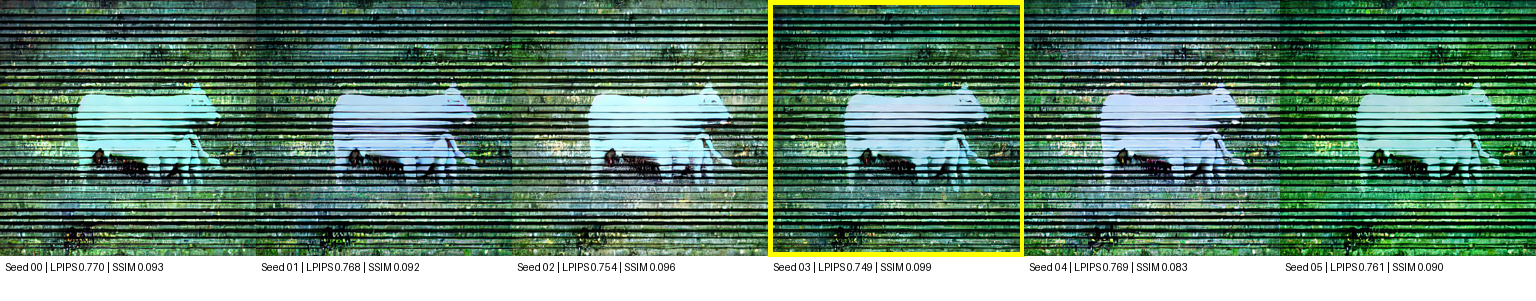


📊 Summary for Image 0000
Best LPIPS Seed: 03 | LPIPS: 0.7487, SSIM: 0.0985, PSNR: 12.21
Best SSIM  Seed: 03 | SSIM: 0.0985, LPIPS: 0.7487
Average over 6 seeds → LPIPS: 0.7617, SSIM: 0.0921, PSNR: 11.67, MSE: 0.06842
💾 Saved best LPIPS result to: /content/drive/MyDrive/Sampling images/coco_20_samples/outputs/Ours/best/best_0000_seed03.png
💾 Saved best SSIM  result to: /content/drive/MyDrive/Sampling images/coco_20_samples/outputs/Ours/best_ssim/best_ssim_0000_seed03.png


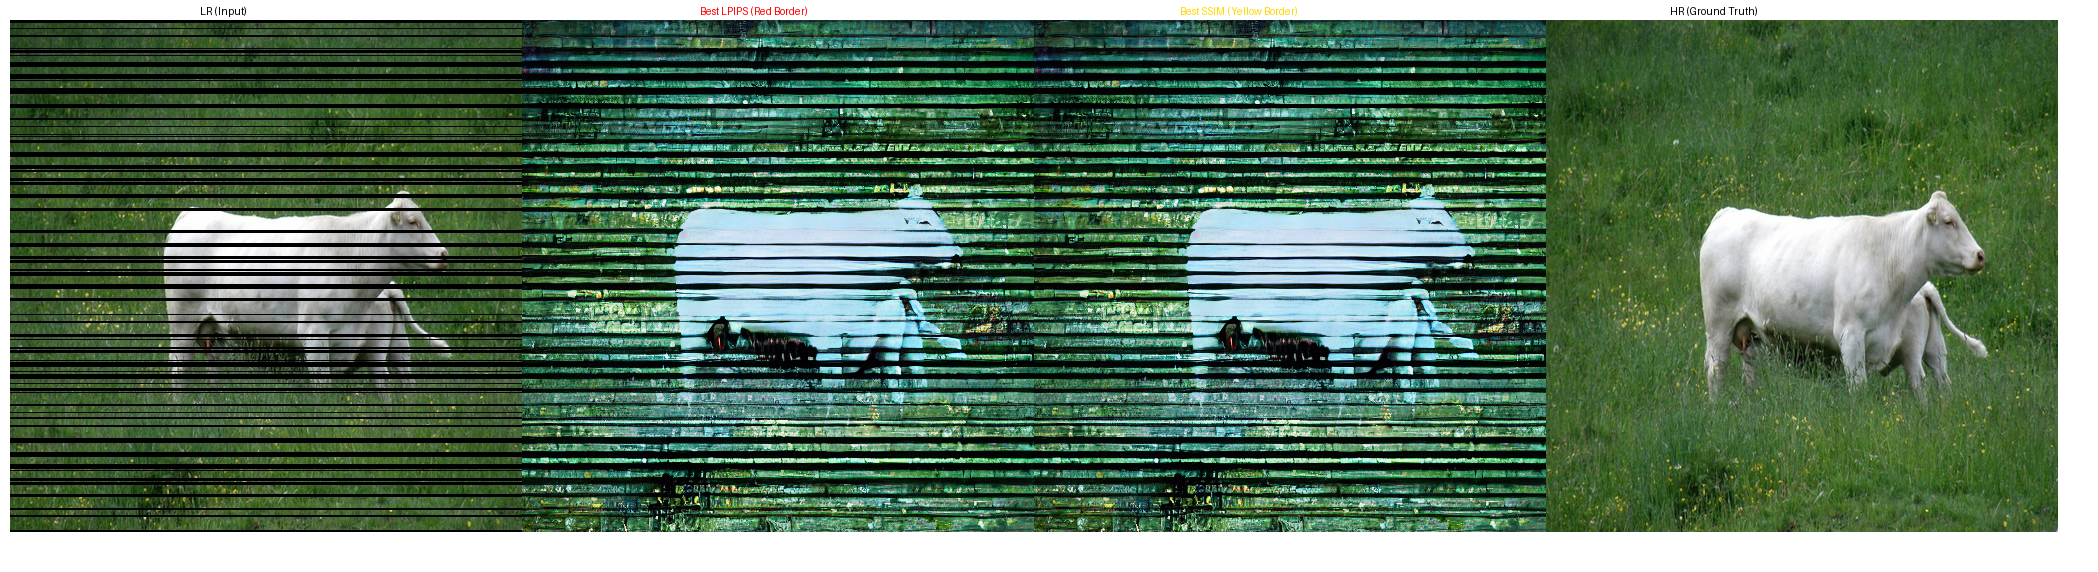


📁 Saved LPIPS-based metrics CSV to: /content/drive/MyDrive/Sampling images/coco_20_samples/outputs/Ours/posterior_best_metrics_lpips.csv
📁 Saved SSIM-based metrics CSV to: /content/drive/MyDrive/Sampling images/coco_20_samples/outputs/Ours/posterior_best_metrics_ssim.csv

=== 🧾 FINAL AVERAGES ===

--- Based on Best LPIPS (Perceptual Quality) ---
Average Best LPIPS: 0.7487
Average SSIM (of Best LPIPS): 0.0985
Average PSNR (of Best LPIPS): 12.21
Average MSE  (of Best LPIPS): 0.06013

--- Based on Best SSIM (Structural Fidelity) ---
Average SSIM (Best SSIM): 0.0985
Average LPIPS (of Best SSIM): 0.7487
Average PSNR (of Best SSIM): 12.21
Average MSE  (of Best SSIM): 0.06013


In [ ]:
import os, torch, tqdm, numpy as np, pandas as pd
from PIL import Image, ImageDraw, ImageFont
from torchvision import transforms
from skimage.metrics import structural_similarity, mean_squared_error, peak_signal_noise_ratio
import lpips
import matplotlib.pyplot as plt

NUN_TEST_IMAGES = 1
gt_dir = "/content/drive/MyDrive/Sampling images/coco_20_samples/gt_512"
striped_dir = "/content/drive/MyDrive/Sampling images/coco_20_samples/striped_512"
control_dir = "/content/drive/MyDrive/Sampling images/coco_20_samples/stripe_control_512"
image_dir = "/content/drive/MyDrive/Sampling images/coco_20_samples/outputs"


# --- CONFIG ---
device = "cuda" if torch.cuda.is_available() else "cpu"
base_save_dir = os.path.join(image_dir, "Ours")
os.makedirs(base_save_dir, exist_ok=True)

lpips_fn = lpips.LPIPS(net='alex').to(device)
to_tensor = transforms.ToTensor()

# Define seeds (custom step size)
seed_values = list(range(0, 6, 1))
num_seeds = len(seed_values)

results = []
results_best_ssim = []

# --- MAIN LOOP ---
for idx in range(NUN_TEST_IMAGES):

    striped_path = os.path.join(striped_dir, f"coco_sample_{idx:03d}.jpg")
    control_path = os.path.join(control_dir, f"coco_sample_{idx:03d}.png")
    gt_path = os.path.join(gt_dir, f"coco_sample_{idx:03d}.jpg")


    gt_t = imread_tensor(gt_path)
    striped_t = imread_tensor(striped_path)
    control_t = imread_tensor(control_path)

    gt = Image.open(gt_path).convert("RGB")
    striped = Image.open(striped_path).convert("RGB")
    control = Image.open(control_path).convert("L")

    # gt = transforms.Resize(gt)
    # striped = transforms.Resize(striped)
    # control = transforms.Resize(control)



    print(gt_t.shape)
    print(striped_t.shape)
    print(control_t.shape)

    # gt_t = transforms.ToTensor(gt)         # (3,H,W), [0,1]
    # striped_t = transforms.ToTensor(striped)
    # control_t =  transforms.ToTensor(control)  # (1,H,W), [0,1]

    # ControlNet condition: 4 channels = striped RGB + stripe control
    LR = torch.cat([striped_t, control_t], dim=0)  # (4,H,W)

    LR[:3, :, :] = LR[:3, :, :] * 2.0 - 1.0
    print(f"\n=== Image {idx:04d} ===")

    # Create folder for this image
    img_save_dir = os.path.join(base_save_dir, f"{idx:04d}")
    os.makedirs(img_save_dir, exist_ok=True)

    # Load data
    # LR = torch.load(os.path.join(tensor_dir, f'lr_tensor_{idx:04d}.pt'))
    # LR[:3] = LR[:3]*2 - 1
    HR_img = gt
    LR_img = striped
    HR_tensor = to_tensor(HR_img).unsqueeze(0).to(device)

    print(HR_img.size)
    print(LR_img.size)
    print(HR_tensor.size)

    # print(os.path.join(image_dir, f'hr_image_{idx:04d}.jpg'))
    # print(os.path.join(image_dir, f'lr_image_{idx:04d}.jpg'))
    # print(os.path.join(tensor_dir, f'lr_tensor_{idx:04d}.pt'))

    # Metric containers
    ssim_vals, lpips_vals, psnr_vals, mse_vals = [], [], [], []

    best_lpips, best_seed, best_img = 1e9, -1, None
    best_metrics = {}

    # --- Loop over seeds ---
    for seed in seed_values:
        print(f"Seed {seed}")
        generator = torch.Generator(device=device).manual_seed(seed)

        with torch.no_grad():
            reconstructed_image = pipeline(
                prompt="a sharp, high-quality photograph",
                image=LR_img,
                control_image=LR.unsqueeze(0).to(device),
                num_inference_steps=200,
                generator=generator,
                guidance_scale=1.0,
                strength=1,
                controlnet_conditioning_scale=2.0
            ).images[0]

        # Compute metrics
        recon_tensor = to_tensor(reconstructed_image).unsqueeze(0).to(device)
        hr_np, recon_np = np.array(HR_img)/255.0, np.array(reconstructed_image)/255.0
        print('hr_max: ',hr_np.max(),'hr_min: ',hr_np.min())
        print('recon_max: ',recon_np.max(),'recon_min: ',recon_np.min())
        ssim_val = structural_similarity(hr_np, recon_np, channel_axis=2, data_range=1)
        lpips_val = lpips_fn(recon_tensor, HR_tensor).mean().item()
        psnr_val = peak_signal_noise_ratio(hr_np, recon_np, data_range=1)
        mse_val = mean_squared_error(hr_np, recon_np)

        ssim_vals.append(ssim_val)
        lpips_vals.append(lpips_val)
        psnr_vals.append(psnr_val)
        mse_vals.append(mse_val)

        print(f"LPIPS: {lpips_val:.4f}, SSIM: {ssim_val:.4f}, PSNR: {psnr_val:.4f}, MSE: {mse_val:.2f}")

        # Save per-seed reconstruction
        seed_path = os.path.join(img_save_dir, f"seed_{seed:02d}.png")
        reconstructed_image.save(seed_path)

        # Save grid visualization
        grid = Image.new('RGB', (512 * 3 + 20, 512 + 40), color="white")
        grid.paste(LR_img, (0, 20))
        grid.paste(reconstructed_image, (512 + 10, 20))
        grid.paste(HR_img, (512 * 2 + 20, 20))
        grid.save(os.path.join(img_save_dir, f"grid_seed_{seed:02d}.png"))

        # Track best LPIPS
        if lpips_val < best_lpips:
            best_lpips = lpips_val
            best_seed = seed
            best_img = reconstructed_image.copy()
            best_metrics = dict(ssim=ssim_val, psnr=psnr_val, mse=mse_val)

    # --- Determine Best SSIM ---
    best_ssim_val = max(ssim_vals)
    best_ssim_seed = seed_values[np.argmax(ssim_vals)]

    # --- Create summary grid ---
    print(f"\n🖼️ Creating summary grid for Image {idx:04d}...")

    cols = 6
    thumb_size = (256, 256)
    rows = int(np.ceil(num_seeds / cols))
    cell_w, cell_h = thumb_size[0], thumb_size[1] + 45

    grid_all = Image.new("RGB", (cols * cell_w, rows * cell_h), color="white")
    draw = ImageDraw.Draw(grid_all)

    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", 16)
    except:
        font = None

    for i, seed_val in enumerate(seed_values):
        seed_img_path = os.path.join(img_save_dir, f"seed_{seed_val:02d}.png")
        if not os.path.exists(seed_img_path):
            continue

        im = Image.open(seed_img_path).resize(thumb_size)
        x = (i % cols) * cell_w
        y = (i // cols) * cell_h
        grid_all.paste(im, (x, y))

        caption = f"Seed {seed_val:02d} | LPIPS {lpips_vals[i]:.3f} | SSIM {ssim_vals[i]:.3f}"
        draw.text((x + 5, y + thumb_size[1] + 5), caption, fill=(0, 0, 0), font=font)

        # Highlight best LPIPS (red)
        if seed_val == best_seed:
            for b in range(5):
                draw.rectangle(
                    [x + b, y + b, x + thumb_size[0] - b, y + thumb_size[1] - b],
                    outline="red"
                )

        # Highlight best SSIM (yellow)
        if seed_val == best_ssim_seed:
            for b in range(5):
                draw.rectangle(
                    [x + b, y + b, x + thumb_size[0] - b, y + thumb_size[1] - b],
                    outline="yellow"
                )

    collage_path = os.path.join(img_save_dir, "all_seeds_grid.png")
    grid_all.save(collage_path)
    print(f"💾 Saved all-seed grid to: {collage_path}")
    display(grid_all)

    # --- Compute averages ---
    avg_lpips = np.mean(lpips_vals)
    avg_ssim  = np.mean(ssim_vals)
    avg_psnr  = np.mean(psnr_vals)
    avg_mse   = np.mean(mse_vals)

    # --- Print summary ---
    print(f"\n📊 Summary for Image {idx:04d}")
    print(f"Best LPIPS Seed: {best_seed:02d} | LPIPS: {best_lpips:.4f}, SSIM: {best_metrics['ssim']:.4f}, PSNR: {best_metrics['psnr']:.2f}")
    print(f"Best SSIM  Seed: {best_ssim_seed:02d} | SSIM: {best_ssim_val:.4f}, LPIPS: {lpips_vals[np.argmax(ssim_vals)]:.4f}")
    print(f"Average over {num_seeds} seeds → LPIPS: {avg_lpips:.4f}, SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.2f}, MSE: {avg_mse:.5f}")

    # --- Save best reconstructions ---
    best_save_dir = os.path.join(base_save_dir, "best")
    best_ssim_save_dir = os.path.join(base_save_dir, "best_ssim")
    os.makedirs(best_save_dir, exist_ok=True)
    os.makedirs(best_ssim_save_dir, exist_ok=True)

    best_path = os.path.join(best_save_dir, f"best_{idx:04d}_seed{best_seed:02d}.png")
    best_img.save(best_path)

    best_ssim_img = Image.open(os.path.join(img_save_dir, f"seed_{best_ssim_seed:02d}.png"))
    best_ssim_path = os.path.join(best_ssim_save_dir, f"best_ssim_{idx:04d}_seed{best_ssim_seed:02d}.png")
    best_ssim_img.save(best_ssim_path)

    print(f"💾 Saved best LPIPS result to: {best_path}")
    print(f"💾 Saved best SSIM  result to: {best_ssim_path}")

    # --- Display comparison (LR | LPIPS | SSIM | HR) ---
    compare_grid = Image.new("RGB", (512 * 4 + 50, 512 + 60), color="white")
    compare_grid.paste(LR_img.resize((512, 512)), (10, 20))
    compare_grid.paste(best_img.resize((512, 512)), (522, 20))
    compare_grid.paste(best_ssim_img.resize((512, 512)), (1034, 20))
    compare_grid.paste(HR_img.resize((512, 512)), (1546, 20))
    draw_compare = ImageDraw.Draw(compare_grid)
    draw_compare.text((200, 5), "LR (Input)", fill="black", font=font)
    draw_compare.text((700, 5), "Best LPIPS (Red Border)", fill="red", font=font)
    draw_compare.text((1180, 5), "Best SSIM (Yellow Border)", fill="gold", font=font)
    draw_compare.text((1670, 5), "HR (Ground Truth)", fill="black", font=font)
    display(compare_grid)

    # --- Record metrics ---
    results.append({
        "image_index": idx,
        "best_seed_lpips": best_seed,
        "best_lpips": best_lpips,
        "best_ssim_lpips": best_metrics["ssim"],
        "best_psnr_lpips": best_metrics["psnr"],
        "best_mse_lpips": best_metrics["mse"],
        "avg_lpips": avg_lpips,
        "avg_ssim": avg_ssim,
        "avg_psnr": avg_psnr,
        "avg_mse": avg_mse,
        "save_path_lpips": best_path
    })

    results_best_ssim.append({
        "image_index": idx,
        "best_seed_ssim": best_ssim_seed,
        "best_lpips_ssim": lpips_vals[np.argmax(ssim_vals)],
        "best_ssim": best_ssim_val,
        "best_psnr_ssim": psnr_vals[np.argmax(ssim_vals)],
        "best_mse_ssim": mse_vals[np.argmax(ssim_vals)],
        "save_path_ssim": best_ssim_path
    })

# --- Save CSVs ---
df_lpips = pd.DataFrame(results)
df_ssim = pd.DataFrame(results_best_ssim)

csv_path_lpips = os.path.join(base_save_dir, "posterior_best_metrics_lpips.csv")
csv_path_ssim = os.path.join(base_save_dir, "posterior_best_metrics_ssim.csv")

df_lpips.to_csv(csv_path_lpips, index=False)
df_ssim.to_csv(csv_path_ssim, index=False)

print(f"\n📁 Saved LPIPS-based metrics CSV to: {csv_path_lpips}")
print(f"📁 Saved SSIM-based metrics CSV to: {csv_path_ssim}")

# --- Final Averages ---
print("\n=== 🧾 FINAL AVERAGES ===")

print("\n--- Based on Best LPIPS (Perceptual Quality) ---")
print(f"Average Best LPIPS: {df_lpips['best_lpips'].mean():.4f}")
print(f"Average SSIM (of Best LPIPS): {df_lpips['best_ssim_lpips'].mean():.4f}")
print(f"Average PSNR (of Best LPIPS): {df_lpips['best_psnr_lpips'].mean():.2f}")
print(f"Average MSE  (of Best LPIPS): {df_lpips['best_mse_lpips'].mean():.5f}")

print("\n--- Based on Best SSIM (Structural Fidelity) ---")
print(f"Average SSIM (Best SSIM): {df_ssim['best_ssim'].mean():.4f}")
print(f"Average LPIPS (of Best SSIM): {df_ssim['best_lpips_ssim'].mean():.4f}")
print(f"Average PSNR (of Best SSIM): {df_ssim['best_psnr_ssim'].mean():.2f}")
print(f"Average MSE  (of Best SSIM): {df_ssim['best_mse_ssim'].mean():.5f}")
